### Import Libraries

In [0]:
import pandas as pd
import numpy as np
from keras import Sequential, layers
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.layers import Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose,Input,Embedding,LSTM,Concatenate,Lambda
from keras.layers import concatenate
import matplotlib.pyplot as plt
from keras import initializers
from keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from keras import backend as K
from keras.utils import to_categorical,plot_model
import random
import numpy as np
import time
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

## Functions for data processing

In [0]:
def convert_to_array(file):
    res = list()
    #Open file and read add every value from a line in a list
    with open(file,'r') as f:
        for line in f:
            res.append(float(line))
    res = np.asarray(res)        
    f.close()
    return res


def read_weather_file(file):
    temp = []
    rain = []
    wind_speed = []
    wind_direction = []
    #Open file which has 5 values
    #Split on comma and add temperature, rain, wind_speed and wind_direction in a list.
    with open(file, 'r') as f:
        f.readline()
        for line in f:
            temp.append(float(line.split(',')[0]))
            rain.append(float(line.split(',')[1]))
            wind_speed.append(float(line.split(',')[2]))
            wind_direction.append(line.split(',')[4].split('\n')[0])
    return (np.asarray(temp), np.asarray(rain), np.asarray(wind_speed), np.asarray(wind_direction))
    

## Read all PM2.5 Input files and see distribution

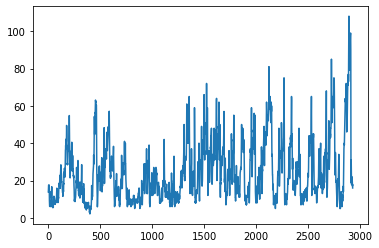

In [4]:
#Read PM 2.5 values
aqi_1 = convert_to_array('aqi_09_2017')
aqi_2 = convert_to_array('aqi_10_2017')
aqi_3 = convert_to_array('aqi_11_2017')
aqi_4 = convert_to_array('aqi_12_2017')

#Concatenate all files for training
data = np.concatenate([aqi_1,aqi_2,aqi_3,aqi_4])
data = data.reshape(2928,1)

#Plot to show the spead and variation of PM2.5 values
plt.plot(data)
plt.show()

In [0]:
#split values for training and validation
split_size = int(data.shape[0]*0.7)
X_train, X_val = data[:split_size], data[split_size:]


In [0]:
#Read test data
X_test = convert_to_array('aqi_01_2018')
X_test = X_test.reshape(X_test.shape[0],1)

## Read weather files for training and data preprocessing

In [7]:
#Read weather data from 4 files for training
# 4 values are returned here as arrays
#temperature, rain, windSpeed and windDirection
temp1,rain1,wind_speed1,wind_direction1 = read_weather_file('weather_09_2017.csv')    
temp2,rain2,wind_speed2,wind_direction2 = read_weather_file('weather_10_2017.csv')
temp3,rain3,wind_speed3,wind_direction3  = read_weather_file('weather_11_2017.csv')
temp4,rain4,wind_speed4,wind_direction4  = read_weather_file('weather_12_2017.csv')


#Concatenate same type of values to one array for training
temp = np.concatenate([temp1,temp2,temp3,temp4])
rain = np.concatenate([rain1,rain2,rain3,rain4])
wind_speed = np.concatenate([wind_speed1,wind_speed2,wind_speed3,wind_speed4])
wind_direction = np.concatenate([wind_direction1,wind_direction1,wind_direction1,wind_direction1])

#Convert wind direction to one hot encoding
le = LabelEncoder().fit(wind_direction.ravel())
enc = OneHotEncoder(sparse=False)
wind_direction = enc.fit_transform(le.transform(wind_direction).reshape(-1,1))
print(wind_direction.shape)

#Reshape arrays for normalizing
temp = temp.reshape(temp.shape[0],1)
rain = rain.reshape(rain.shape[0],1)
wind_speed = wind_speed.reshape(wind_speed.shape[0],1)

#Normalize values
scaler_temp = StandardScaler().fit(temp)
scaler_rain = StandardScaler().fit(rain)
scaler_wind_speed = StandardScaler().fit(wind_speed)
temp = scaler_temp.transform(temp)
rain = scaler_rain.transform(rain)
wind_speed = scaler_wind_speed.transform(wind_speed)

#Split weather variables into training and validation
temp_train, temp_val = temp[:split_size], temp[split_size:]
rain_train, rain_val = rain[:split_size], rain[split_size:]
wind_speed_train, wind_speed_val = wind_speed[:split_size], wind_speed[split_size:]
wind_direction_train, wind_direction_val = wind_direction[:split_size], wind_direction[split_size:]

(2880, 16)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Read testing files for weather and preprocess

In [8]:
#Testing data
temp_test,rain_test,wind_speed_test,wind_direction_test = read_weather_file('weather_12_2017.csv')
temp_test = temp_test.reshape(temp_test.shape[0],1)
rain_test = rain_test.reshape(rain_test.shape[0],1)
wind_speed_test = wind_speed_test.reshape(wind_speed_test.shape[0],1)
            
#Normalize test values
scaler_temp = StandardScaler().fit(temp_test)
scaler_rain = StandardScaler().fit(rain_test)
scaler_wind_speed = StandardScaler().fit(wind_speed_test)
temp_test = scaler_temp.transform(temp_test)
rain_test = scaler_rain.transform(rain_test)
wind_speed_test = scaler_wind_speed.transform(wind_speed_test)

#Wind_direction test 
le = LabelEncoder().fit(wind_direction_test.ravel())
enc = OneHotEncoder(sparse=False)
wind_direction_test = enc.fit_transform(le.transform(wind_direction_test).reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Below three cells have different variants of hybrid model. I have tried all and picked the best one.

#### This model is without the use of alpha as proposed in the paper

In [0]:
def hybrid_model():
    inpA = Input(shape=(24,1))
    model1 = LSTM(4,input_shape = (1,24,1))(inpA)
    model1 = Dense(1)(model1)
    model1 = Model(inputs= inpA,outputs = model1)
    inpB = Input(shape=(45,))
    model2 = Dense(512)(inpB)
    model2 = Model(inputs= inpB,outputs = model2)
    hybrid = concatenate([model1.output,model2.output])
    #z = Dense(2, activation="relu")(hybrid)
    z = Dense(1, activation="linear")(hybrid)
    model = Model(inputs=[model1.input, model2.input], outputs=z)
    return model
    

#### This model is using alpha, with 2 LSTM layers.

In [0]:
def hybrid_model3():
    inpA = Input(shape=(24,1))
    model1 = LSTM(128,input_shape = (1,24,1),return_sequences=True)(inpA)
    model1 = LSTM(4)(model1)
    model1 = Dense(1)(model1)
    #model1 = Lambda(lambda x: x * alpha)(model1)
    #k.backend.dot(model1,alpha)
    #model1 = model1 * alpha
    model1 = Model(inputs= inpA,outputs = model1)
    inpB = Input(shape=(19,))
    model2 = Dense(512)(inpB)
    model2 = Model(inputs= inpB,outputs = model2)
    hybrid = concatenate([model1.output,model2.output])
    #z = Dense(2, activation="relu")(hybrid)
    z = Dense(1, activation="linear")(hybrid)
    #z = Lambda(lambda x: x * (1-alpha))(z)
    #z = z* (1-alpha)
    model = Model(inputs=[model1.input, model2.input], outputs=z)
    return model
    

#### This model is using alpha, with 1 LSTM layer.

In [0]:
alpha = 0.3
def hybrid_model2():
    #Define model1
    inpA = Input(shape=(24,1))
    model1 = LSTM(128,input_shape = (1,24,1))(inpA)
    model1 = Dense(1)(model1)
    model1 = Lambda(lambda x: x * alpha)(model1)
    
    #Define model2
    model1 = Model(inputs= inpA,outputs = model1)
    inpB = Input(shape=(45,))
    model2 = Dense(512)(inpB)
    model2 = Lambda(lambda x: x * (1-alpha))(model2)
    model2 = Model(inputs= inpB,outputs = model2)

    #Merge both models
    hybrid = concatenate([model1.output,model2.output])
    z = Dense(1, activation="linear")(hybrid)
    model = Model(inputs=[model1.input, model2.input], outputs=z)
    return model

In [0]:
#Call hybrid model2
model = hybrid_model2()
opt = Adam(lr=0.01)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [0]:
# Below three functions are imported from github:
 # https://github.com/vanduc103/air_analysis_v1/blob/master/hybrid_model_final.py

def time2onehot(timeidx):
    t = timeidx - (timeidx//24)*24
    result = np.zeros(24)
    result[t] = 1
    return result

def date2onehot_train(timeidx):
    basetime = time.mktime((2017, 9, 1, 0, 0, 0, 0, 1, 1)) # 2017-09-01 00:00:00
    d = time.localtime(basetime + timeidx * 3600)
    wday = d.tm_wday

    result = np.zeros(2)
    holidays = [276, 277, 278, 279, 282, 359]
    # weekend and holiday
    if wday == 5 or wday == 6 or d.tm_yday in holidays:
        result[1] = 1
    else:
        result[0] = 1
    return result

pred_timesteps = 12
def batch_creator(batch_size, dataset_length, timesteps):
    batch_x = list()
    batch_y = list()
    batch_x_w = list()

    """Create batch with random samples and return appropriate format"""
    #batch_mask = rng.choice(dataset_length-timesteps, batch_size)
    offset_rand = random.randrange(0, dataset_length - timesteps - batch_size - pred_timesteps)
    for i in range(batch_size):
        offset = offset_rand + i
        batch_x.append(X_train[offset:offset+timesteps])
        batch_y.append(X_train[offset+timesteps])
        x_w = np.concatenate([temp_train[offset+timesteps], rain_train[offset+timesteps], wind_speed_train[offset+timesteps], wind_direction_train[offset+timesteps]], axis = 0)
        # make time, date onehot
        time_onehot = time2onehot(offset+timesteps)
        date_onehot = date2onehot_train(offset+timesteps)
        x_w = np.concatenate([x_w, np.concatenate([time_onehot, date_onehot], axis=0)], axis=0)
        
        batch_x_w.append(x_w)
    
    return np.asarray(batch_x), np.asarray(batch_x_w), np.asarray(batch_y)


In [0]:
tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/DLProject1/hybrid_final',
  histogram_freq=0,
  batch_size=64,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(model)

### Start training

In [24]:
training_steps = 10000
batch_size = 256
timesteps = 24

for step in range(1, training_steps+1):
      # Make the training batch for each step
      batch_x, batch_x_w, batch_y = batch_creator(batch_size, X_train.shape[0], timesteps)
      loss = model.train_on_batch([batch_x,batch_x_w],batch_y)
      if step%1000==0:
        tensorboard.on_epoch_end(step, {"loss":loss}) 
        print(loss)

12.794994
9.996782
9.667364
9.56062
10.374559
9.908415
10.276106
12.71353
10.676891
10.068535


### Read testing PM2.5 data

In [0]:
X_test = convert_to_array('aqi_01_2018')
#X_test = X_test.reshape(X_test.shape[0],1)

In [0]:
def batch_creator2(batch_size, dataset_length, timesteps):
    batch_x = list()
    batch_y = list()
    batch_x_w = list()

    """Create batch with random samples and return appropriate format"""
    #batch_mask = rng.choice(dataset_length-timesteps, batch_size)
    offset_rand = random.randrange(0, dataset_length - timesteps - batch_size - pred_timesteps)
    for i in range(batch_size):
        offset = offset_rand + i
        batch_x.append(X_val[offset:offset+timesteps])
        batch_y.append(X_val[offset+timesteps])
        x_w = np.concatenate([temp_val[offset+timesteps], rain_val[offset+timesteps], wind_speed_val[offset+timesteps], wind_direction_val[offset+timesteps]], axis = 0)
        # make time, date onehot
        time_onehot = time2onehot(offset+timesteps)
        date_onehot = date2onehot_train(offset+timesteps)
        x_w = np.concatenate([x_w, np.concatenate([time_onehot, date_onehot], axis=0)], axis=0)
        
        batch_x_w.append(x_w)
    
    return np.asarray(batch_x), np.asarray(batch_x_w), np.asarray(batch_y)


In [26]:
test_x, test_x_w, test_y =batch_creator2(batch_size,X_val.shape[0],timesteps)
test_x.shape

(256, 24, 1)

### See predicted values

In [27]:
#TEST
y = model.predict([test_x,test_x_w])
print('Predicted '+' '+'Real value')
for i in range(len(y)):
  print(str(np.round(y[i],0))+' '+str(test_y[i]))


Predicted  Real value
[16.] [15.]
[14.] [16.]
[17.] [20.]
[21.] [22.]
[24.] [25.]
[27.] [22.]
[23.] [24.]
[26.] [30.]
[31.] [27.]
[25.] [28.]
[29.] [25.]
[25.] [21.]
[21.] [21.]
[22.] [19.]
[20.] [18.]
[18.] [19.]
[21.] [19.]
[20.] [20.]
[21.] [20.]
[20.] [21.]
[22.] [24.]
[25.] [27.]
[27.] [30.]
[31.] [27.]
[26.] [29.]
[29.] [29.]
[30.] [29.]
[30.] [29.]
[31.] [27.]
[26.] [30.]
[31.] [31.]
[33.] [33.]
[34.] [34.]
[36.] [42.]
[43.] [48.]
[47.] [47.]
[48.] [43.]
[36.] [29.]
[21.] [22.]
[22.] [26.]
[27.] [23.]
[23.] [26.]
[25.] [29.]
[28.] [28.]
[27.] [34.]
[37.] [30.]
[23.] [16.]
[13.] [12.]
[11.] [12.]
[11.] [12.]
[12.] [11.]
[12.] [8.]
[9.] [7.]
[8.] [7.]
[8.] [7.]
[9.] [10.]
[11.] [12.]
[13.] [12.]
[12.] [11.]
[11.] [11.]
[11.] [11.]
[12.] [13.]
[13.] [12.]
[12.] [10.]
[11.] [10.]
[11.] [9.]
[9.] [10.]
[11.] [9.]
[10.] [9.]
[10.] [9.]
[9.] [10.]
[11.] [10.]
[11.] [12.]
[14.] [9.]
[9.] [9.]
[10.] [7.]
[10.] [9.]
[10.] [12.]
[14.] [14.]
[15.] [14.]
[14.] [14.]
[14.] [14.]
[14.] [12.]
[

### Evaluate loss

In [28]:
model.evaluate([test_x,test_x_w],test_y)

256/256 [==============================] - 0s 1ms/step


10.435007691383362

Plot Predict Values

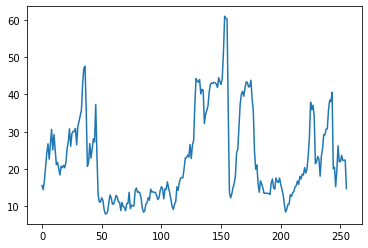

In [29]:
plt.plot(y)
plt.show()